In [18]:
#data manipulation

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor



In [14]:
#Timer function
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        duration = (datetime.now() - start_time).total_seconds()
        print("Took %i seconds" % duration)

In [7]:

df = pd.read_csv('../Data/train.csv')
dt = pd.read_csv('../Data/test.csv')

In [3]:
df.head(3)

,Index,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
0,0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,0.000022,0.000044,0.002212,6.214737e-07,200.000000,-0.000196,1.533780
1,1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,0.000042,0.000042,0.010932,3.414868e-05,300.000000,-0.003798,0.843604
2,2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,0.000001,0.000002,0.000306,4.079460e-08,159.692076,-0.000003,29.824024


In [15]:
c = df.columns
c

Index(['Index', 'Market', 'Day', 'Stock', 'x0', 'x1', 'x2', 'x3A', 'x3B',
       'x3C', 'x3D', 'x3E', 'x4', 'x5', 'x6', 'y', 'Weight'],
      dtype='object')

In [8]:
#get rid of NaN values
#find out which columns has null values
columns = df.columns
for i in range(len(df.columns)):
    index = df.index[df[columns[i]].isnull()]
    if index.shape[0]>0:
        print(df.columns[i],index.shape)
        df[columns[i]] = df[columns[i]].fillna(0)
columns2 = dt.columns
for i in range(len(dt.columns)):
    index2 = dt.index[dt[columns2[i]].isnull()]
    if index2.shape[0]>0:
        print(dt.columns[i],index2.shape)
        dt[columns2[i]] = dt[columns2[i]].fillna(0)

x1 (55,)
x2 (5,)
x1 (62,)
x2 (2,)


In [9]:
#training dataset and test dataset
x_train = df.drop(['Weight','y'],axis = 1)
x_weight = np.array(df.Weight)
y_train = df.y
x_test = dt

In [32]:
#regression modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [49]:
# predict result with trained model
yp = pd.Series(model.predict(x_test)).rename('y')
yp.index.name = 'Index'

In [50]:
# save predicted data to csv
yp.to_csv('XGBoostRegressor_model.csv', header=True)

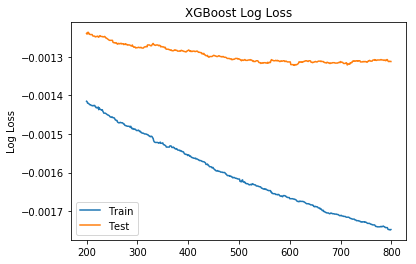

In [145]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis[200:800], results['validation_0']['logloss'][200:800], label='Train')
ax.plot(x_axis[200:800], results['validation_1']['logloss'][200:800], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


In [47]:
def BestStoppingRounds(XGBmodel,
                       x_train,
                       y_train,
                       weight,
                       eval_metric = 'mae'):
    result_set = []
    kf = KFold(n_splits=10)
    fold = 0
    for train_index, test_index in kf.split(x_train):
        fold += 1
        xfold_train, xfold_test = x_train.values[train_index], x_train.values[test_index]
        yfold_train, yfold_test = y_train.values[train_index], y_train.values[test_index]
        xfold_weight = weight[train_index]
        eval_set = ([xfold_train,yfold_train],[xfold_test, yfold_test])
        XGBmodel.fit(xfold_train,
                     yfold_train,
                     sample_weight = xfold_weight,
                     early_stopping_rounds = 10,
                     eval_metric=[eval_metric],
                     eval_set=eval_set,
                     verbose=True)
        # evaluate predictions
        best_score = XGBmodel.best_score
        best_iteration = XGBmodel.best_iteration
        result_set.append([best_score, XGBmodel.best_iteration])
        print("Minimum " + eval_metric + " : %f" %best_score)
        print("Best iteration: %d" %best_iteration)
    return result_set

In [48]:
# Tune XGBoost hyperparameters
# Part 1: set a low learning rate and find the best stopping point

XGBmodel = XGBRegressor(learning_rate = 0.1,
                        n_estimators = 1000)

result_set = BestStoppingRounds(XGBmodel, x_train, y_train, x_weight, 'mae')


[0]	validation_0-mae:0.449946	validation_1-mae:0.449733
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.404947	validation_1-mae:0.404733
[2]	validation_0-mae:0.364447	validation_1-mae:0.364234
[3]	validation_0-mae:0.327997	validation_1-mae:0.327784
[4]	validation_0-mae:0.295193	validation_1-mae:0.294979
[5]	validation_0-mae:0.265669	validation_1-mae:0.265455
[6]	validation_0-mae:0.239097	validation_1-mae:0.238883
[7]	validation_0-mae:0.215182	validation_1-mae:0.214969
[8]	validation_0-mae:0.193659	validation_1-mae:0.193446
[9]	validation_0-mae:0.174291	validation_1-mae:0.17408
[10]	validation_0-mae:0.15686	validation_1-mae:0.156652
[11]	validation_0-mae:0.141172	validation_1-mae:0.140966
[12]	validation_0-mae:0.12705	validation_1-mae:0.126844
[13]	validation_0-mae:0.114343	validation_1-mae:0.114141
[14]	validation_0-mae:0.102908	validation_1-mae:0.102711
[

best_stopping: 103
mean mae: 0.000381


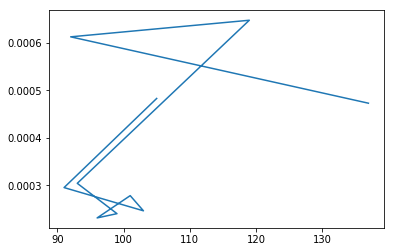

In [50]:
#Find the best stopping point
result_array = np.array(result_set)
plt.plot(result_array[:,1],result_array[:,0])
#take the mean of stopping points
mean_mae = result_array[:,0].mean()
best_stopping = int(result_array[:,1].mean())
print("best_stopping: %d" %best_stopping)
print("mean mae: %f" %mean_mae)


In [26]:
def XGBTuneParam(XGBmodel,
                 param_grid,
                 x_train,
                 y_train,
                 weight):

    xgbcv = GridSearchCV(XGBmodel,param_grid)
    if type(weight)==str:
        xgbcv.fit(x_train,y_train)
    else:
        xgbcv.fit(x_train,y_train,weight)
    return xgbcv, xgbcv.best_score_, xgbcv.best_params_


In [21]:
# Part 2: Tune max_depth and mean_child_weight
# best fit parameter: learning_rate = 0.1, max_depth = 6, min_child_weight = 2
XGBmodel = XGBRegressor(learning_rate = 0.1, 
                        n_estimators = best_stopping
                       )
param_grid = { 
        "max_depth"             : [2, 4, 6],
        "min_child_weight"      : [2, 4, 8]
        }

Tune2model, Tune2score, Tune2params = XGBTuneParam(XGBmodel,
                                                   param_grid,
                                                   x_train,
                                                   y_train,
                                                   x_weight)

Tuned_max_depth = Tune2params['max_depth']
Tuned_min_child_weight = Tune2params['min_child_weight']
print("max_depth %d" %Tune2params['max_depth'])
print("min_child_weight %f" %Tune2params['min_child_weight'])
print("Accuracy_score %f" %Tune2score)

max_depth 6
min_child_weight 2.000000
Accuracy_score 0.138555


In [41]:
Tune2model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=132,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [33]:
# Part 3: Tune gamma
# best fit parameter: gamma = 0.0
XGBmodel = Tune2model

param_grid = { 
        "gamma"             : [0.0, 0.1, 0.2]
        }

Tune3model, Tune3score, Tune3params = XGBTuneParam(XGBmodel,
                                                   param_grid,
                                                   x_train,
                                                   y_train,
                                                   x_weight) 
Tuned_gamma = Tune3params["gamma"]
print("gamma %f" %Tuned_gamma)
print("Accuracy_score %f" %Tune3score)


gamma 0.000000
Accuracy_score 0.138555


In [42]:
Tune3model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=132,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

[0]	validation_0-mae:0.449946	validation_1-mae:0.449733
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.404947	validation_1-mae:0.404733
[2]	validation_0-mae:0.364447	validation_1-mae:0.364234
[3]	validation_0-mae:0.327997	validation_1-mae:0.327784
[4]	validation_0-mae:0.295193	validation_1-mae:0.294979
[5]	validation_0-mae:0.265669	validation_1-mae:0.265455
[6]	validation_0-mae:0.239097	validation_1-mae:0.238883
[7]	validation_0-mae:0.215182	validation_1-mae:0.214969
[8]	validation_0-mae:0.193659	validation_1-mae:0.193446
[9]	validation_0-mae:0.174291	validation_1-mae:0.17408
[10]	validation_0-mae:0.15686	validation_1-mae:0.156652
[11]	validation_0-mae:0.141172	validation_1-mae:0.140966
[12]	validation_0-mae:0.12705	validation_1-mae:0.126844
[13]	validation_0-mae:0.114343	validation_1-mae:0.114141
[14]	validation_0-mae:0.102908	validation_1-mae:0.102711
[

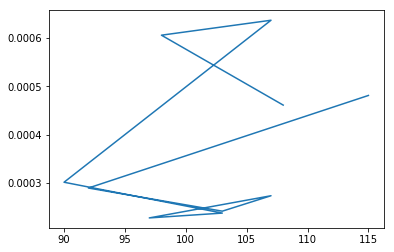

In [51]:
# Revisit best stopping rounds

XGBmodel = XGBRegressor(learning_rate = 0.1,
                        gamma = Tuned_gamma,
                        max_depth = Tuned_max_depth,
                        min_child_weight = Tuned_min_child_weight,
                        n_estimators = 1000)
     
result_set = BestStoppingRounds(XGBmodel, x_train, y_train, x_weight)

#Find the best stopping point
result_array = np.array(result_set)
plt.plot(result_array[:,1],result_array[:,0])
#take the mean of stopping points
mean_mae = result_array[:,0].mean()
best_stopping = int(result_array[:,1].mean())
print("best_stopping: %d" %best_stopping)
print("mean mae: %f" %mean_mae)


In [39]:
# Part 4: Tune colsample_bytree and subsample
# best fit parameter: colsample_bytree = 0.7, subsample = 1
XGBmodel = XGBRegressor(learning_rate = 0.1,
                       gamma = Tuned_gamma,
                       max_depth = Tuned_max_depth,
                       min_child_weight = Tuned_min_child_weight,
                       n_estimators= best_stopping)

param_grid = { 
        "subsample"         : [i/10 for i in range(7,11)],
        "colsample_bytree"  : [i/10 for i in range(7,11)]
        }

Tune4model, Tune4score, Tune4params = XGBTuneParam(XGBmodel,
                                                   param_grid,
                                                   x_train,
                                                   y_train,
                                                   x_weight)
Tuned_subsample = Tune4params['subsample']
Tuned_colsample_bytree = Tune4params['colsample_bytree']
print("subsample %f" %Tuned_subsample)
print("colsample_bytree %f" %Tuned_colsample_bytree)
print("Accuracy_score %f" %Tune4score)


subsample 1.000000
colsample_bytree 0.700000
Accuracy_score 0.147002


In [69]:
#Part 5: Tune learning rate
# The slower the learning rate, the more boosting rounds will be needed, and the longer
# it will take to train
# Find the optimal trade off between time and error
from sklearn.model_selection import GridSearchCV
def XGBTunePart4(XGBmodel, x_train, y_train, weight):
    param_grid = { 
            "subsample"             : [0.6,0.8,1],
            "colsample_bytree"      : [0.6,0.8,1],
            }
    xgbcv = GridSearchCV(XGBmodel,param_grid)
    if type(weight)==str:
        xgbcv.fit(x_train,y_train)
    else:
        xgbcv.fit(x_train,y_train,weight)
    return xgbcv.best_score_, xgbcv.best_params_
Tune4model, Tune4score, Tune4params = XGBTunePart4(XGBmodel, x_train,y_train,x_weight) 

In [74]:
    #XGBoost with more tuned parameters 0.45
    XGBmodel = XGBRegressor(learning_rate = 0.1, 
                            n_estimators = best_stopping,
                            max_depth = 6,
                            min_child_weight = 4,
                            colsample_bytree = 0.8,
                            subsmaple = 1
                           )
XGBmodel.fit(x_train, y_train, x_weight)
print(XGBmodel.score(x_train, y_train, x_weight))

0.4538327636217999
